In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from ucimlrepo import fetch_ucirepo

## Explicación del Proceso de Preparación y División del Conjunto de Datos del Cáncer de Mama de Wisconsin

### Objetivo
El proceso descrito se centra en la preparación y división del conjunto de datos del cáncer de mama de Wisconsin para su análisis y modelado.

### Descripción del Proceso

1. **Carga del Conjunto de Datos**: 
   - Se accede y carga el conjunto de datos del cáncer de mama de Wisconsin desde un repositorio en línea, específicamente de UCI (Universidad de California, Irvine).

2. **Extracción de Características y Etiquetas**: 
   - Las características (`X`) y las etiquetas objetivo (`y`) se extraen del conjunto de datos. Las características incluyen diversos indicadores médicos, mientras que las etiquetas representan la presencia o ausencia de cáncer.

3. **Transformación de Etiquetas**: 
   - Las etiquetas, que originalmente indican la presencia de cáncer con el número 4, se transforman a 1, y todas las demás etiquetas (indicando ausencia de cáncer) se transforman a 0. Esto simplifica el análisis convirtiéndolo en un problema de clasificación binaria.

4. **Creación y Limpieza de un DataFrame de pandas**: 
   - Se crea un DataFrame usando las características y las etiquetas transformadas.
   - Se eliminan las filas que contienen valores faltantes (NaN) para mantener la integridad y la calidad de los datos.

5. **Preparación de Datos para el Modelado**: 
   - Las características y etiquetas se separan nuevamente, quedando listas para ser usadas en la formación y evaluación de modelos de aprendizaje automático.

6. **División en Conjuntos de Entrenamiento y Prueba**: 
   - Los datos se dividen en conjuntos de entrenamiento y prueba. Una proporción común es reservar el 20% de los datos para pruebas, lo que permite evaluar la eficacia del modelo en datos no vistos.

### Conclusión
Este proceso meticuloso garantiza que el conjunto de datos del cáncer de mama esté bien preparado y libre de inconsistencias, lo que es fundamental para desarrollar modelos precisos y confiables en el campo de la detección y diagnóstico del cáncer.

In [2]:
breast_cancer_wisconsin_original = fetch_ucirepo(id=15) 
X = breast_cancer_wisconsin_original.data.features 
y = breast_cancer_wisconsin_original.data.targets
y = np.where(y == 4, 1, 0)
y = y.astype(int)
y = y.flatten()

data_breast_cancer = pd.DataFrame(X, columns=breast_cancer_wisconsin_original.data.feature_names)
data_breast_cancer['label'] = y

nan_rows = np.isnan(data_breast_cancer).any(axis=1)
data_breast_cancer = data_breast_cancer[~nan_rows]
X_breast_cancer = data_breast_cancer.drop(columns=['label']).values
y_breast_cancer = data_breast_cancer['label'].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_breast_cancer, X_test_breast_cancer, y_train_breast_cancer, y_test_breast_cancer = train_test_split(X_breast_cancer, y_breast_cancer, test_size=0.2, random_state=42, stratify=y_breast_cancer)

## Explicación del Proceso de Preparación y División de Datos del Conjunto de Datos de Frijoles Secos

### Objetivo
El proceso descrito se enfoca en la preparación y división del conjunto de datos de frijoles secos para su posterior análisis y modelado.

### Pasos del Proceso

1. **Carga del Conjunto de Datos**: 
   - Se obtiene el conjunto de datos de frijoles secos desde un repositorio en línea, específicamente el repositorio UCI.

2. **Extracción de Características y Etiquetas**: 
   - Las características (`X`) y etiquetas objetivo (`y`) se extraen del conjunto de datos cargado.

3. **Transformación de Etiquetas de Texto a Numéricas**: 
   - Las etiquetas de clase, originalmente en formato de texto (como 'SEKER', 'BARBUNYA', etc.), se convierten en valores numéricos para facilitar su manejo en análisis posteriores. Cada tipo de frijol recibe un número entero único.

4. **Conversión de Tipo de Dato de Etiquetas**: 
   - Las etiquetas convertidas se transforman explícitamente a tipo de dato entero para asegurar la coherencia y compatibilidad con algoritmos de aprendizaje automático.

5. **Creación de un DataFrame de pandas**: 
   - Se crea un DataFrame utilizando las características y las etiquetas numéricas. Este DataFrame facilita la manipulación y análisis de los datos.

6. **Limpieza de Datos**: 
   - Se eliminan las filas con valores faltantes (NaN) para asegurar la integridad de los datos.

7. **Separación en Características y Etiquetas**: 
   - Las características y etiquetas se separan nuevamente en preparación para el entrenamiento del modelo.

8. **División en Conjuntos de Entrenamiento y Prueba**: 
   - Finalmente, los datos se dividen en conjuntos de entrenamiento y prueba utilizando una proporción estándar (usualmente el 20% de los datos se reserva para pruebas).

### Conclusión
Este proceso resulta en un conjunto de datos limpio y bien estructurado, listo para ser utilizado en tareas de clasificación o análisis de datos. La transformación y limpieza de datos son pasos esenciales para garantizar la eficacia y precisión de los modelos de aprendizaje automático que se apliquen posteriormente.


In [3]:
dry_bean_dataset = fetch_ucirepo(id=602) 
  
X = dry_bean_dataset.data.features 
y = dry_bean_dataset.data.targets 
y = np.where(y == 'SEKER', 0, y)
y = np.where(y == 'BARBUNYA', 1, y)
y = np.where(y == 'BOMBAY', 2, y)
y = np.where(y == 'CALI', 3, y)
y = np.where(y == 'HOROZ', 4, y)
y = np.where(y == 'SIRA', 5, y)
y = np.where(y == 'DERMASON', 6, y)
# Cambiar el tipo de dato de las etiquetas a entero
y = y.astype(int)
y = y.flatten()

data_dry_bean = pd.DataFrame(X, columns=dry_bean_dataset.data.feature_names)
data_dry_bean['label'] = y
data_dry_bean = data_dry_bean.dropna()
X_dry_bean = data_dry_bean.drop(columns=['label']).values
y_dry_bean = data_dry_bean['label'].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_dry_bean, X_test_dry_bean, y_train_dry_bean, y_test_dry_bean = train_test_split(X_dry_bean, y_dry_bean, test_size=0.2, random_state=42, stratify=y_dry_bean)

## Explicación del Proceso de Preparación y División del Conjunto de Datos de Arroz 'Cammeo' y 'Osmancik'

### Objetivo
Este proceso detalla los pasos para preparar y dividir un conjunto de datos de variedades de arroz, específicamente 'Cammeo' y 'Osmancik', para su análisis y modelado.

### Descripción del Proceso

1. **Carga del Conjunto de Datos**: 
   - Se accede y carga el conjunto de datos de arroz 'Cammeo' y 'Osmancik' desde el repositorio en línea de UCI.

2. **Extracción de Características y Etiquetas**: 
   - Se extraen las características (`X`) y las etiquetas objetivo (`y`) del conjunto de datos. Las características incluyen aspectos físicos y químicos del arroz.

3. **Transformación de Etiquetas de Texto a Numéricas**: 
   - Las etiquetas originales, que son nombres de variedades de arroz, se transforman en valores numéricos para su procesamiento. 'Cammeo' se convierte en 0 y 'Osmancik' en 1.

4. **Conversión de Tipo de Dato de Etiquetas**: 
   - Las etiquetas transformadas se convierten a tipo entero para garantizar la uniformidad en el análisis y en los algoritmos de aprendizaje automático.

5. **Creación y Limpieza de un DataFrame de pandas**: 
   - Se crea un DataFrame con las características y etiquetas numéricas.
   - Se eliminan las filas con valores faltantes (NaN) para asegurar la integridad de los datos.

6. **Preparación de Datos para Modelado**: 
   - Se separan las características y las etiquetas para su uso en entrenamiento y pruebas de modelos de aprendizaje automático.

7. **División en Conjuntos de Entrenamiento y Prueba**: 
   - Los datos se dividen en conjuntos de entrenamiento y prueba, típicamente reservando un 20% para pruebas. Esta división permite evaluar la efectividad del modelo en datos no vistos previamente.

### Conclusión
Este proceso metodológico asegura que el conjunto de datos de arroz 'Cammeo' y 'Osmancik' esté preparado adecuadamente, libre de datos faltantes y con etiquetas claramente definidas, facilitando su uso en aplicaciones de aprendizaje automático para clasificación o análisis detallado.


In [4]:
rice_cammeo_and_osmancik = fetch_ucirepo(id=545) 
  
# data (as pandas dataframes) 
X = rice_cammeo_and_osmancik.data.features 
y = rice_cammeo_and_osmancik.data.targets  
labels = np.unique(y)
y = np.where(y == 'Cammeo', 0, y)
y = np.where(y == 'Osmancik', 1, y)

# Cambiar el tipo de dato de las etiquetas a entero
y = y.astype(int)
y = y.flatten()

data_rice = pd.DataFrame(X, columns=rice_cammeo_and_osmancik.data.feature_names)
data_rice['label'] = y

# Eliminar filas con valores nulos
data_rice = data_rice.dropna()
X_rice = data_rice.drop(columns=['label']).values

# Inicialización del escalador MinMax
scaler = MinMaxScaler()

# Ajustar el escalador a las características y transformarlas
X_rice = scaler.fit_transform(X_rice)

y_rice = data_rice['label'].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_rice, X_test_rice, y_train_rice, y_test_rice = train_test_split(X_rice, y_rice, test_size=0.2, random_state=42, stratify=y_rice)

## Clasificador Basado en Estimador de Densidad por Kernels

### Descripción General
El clasificador utiliza un enfoque basado en el estimador de densidad kernel para determinar la probabilidad de que un conjunto de datos pertenezca a una clase en particular. Este método es útil en situaciones donde las distribuciones de clase son continuas y pueden ser aproximadas por densidades suaves.

### Implementación
La implementación consta de dos componentes principales:
- **Función `kernel_density_estimator`**: Calcula la estimación de densidad kernel para un conjunto de puntos utilizando un conjunto de datos de referencia y un parámetro de ancho de banda.
- **Clase `KernelDensityClassifier`**: Inicializa el clasificador con un ancho de banda especificado, aprende las densidades de cada clase en los datos de entrenamiento, y luego utiliza estas densidades para predecir las clases de nuevas observaciones.

### Uso del Clasificador
Para usar el clasificador, se debe primero entrenarlo con un conjunto de datos etiquetados y luego utilizarlo para hacer predicciones sobre nuevos datos. El entrenamiento se realiza mediante el método `fit`, y las predicciones se generan con el método `predict`.

### Consideraciones
- La elección del `bandwidth` es crucial para el rendimiento del clasificador.
- Es adecuado para datos con distribuciones suaves y continuas.
- Es importante asegurar que los datos estén correctamente formateados y preprocesados.

In [5]:
# Estimador de densidad kernel
def kernel_density_estimator(x, data, bandwidth):
    """
    Calcula la estimación de densidad kernel para un conjunto de puntos.

    Args:
    x (array-like): Punto o conjunto de puntos para los cuales se calcula la estimación de densidad.
    data (array-like): Conjunto de datos de referencia utilizado para la estimación de densidad.
    bandwidth (float): Ancho de banda del kernel, controla la suavidad de la estimación de densidad.

    Returns:
    array-like: Estimación de densidad para cada punto en `x`.
    """
    n = len(data)  # Número de puntos en el conjunto de datos de referencia
    # Calcula la densidad para cada punto en 'x' utilizando un kernel Gaussiano
    densities = np.sum(np.exp(-0.5 * ((x - data) / bandwidth)**2) / (np.sqrt(2 * np.pi) * bandwidth), axis=1)
    return densities / n  # Normaliza la densidad por el número de puntos en 'data'

# Clasificador basado en estimador de densidad kernel ajustado
class KernelDensityClassifier:
    def __init__(self, bandwidth=1.0):
        """
        Inicializa el clasificador basado en estimador de densidad kernel.

        Args:
        bandwidth (float): Ancho de banda para el estimador de densidad kernel.
        """
        self.bandwidth = bandwidth  # Ancho de banda para el kernel
        self.classes_ = None  # Almacenará las clases únicas en los datos
        self.densities_ = None  # Almacenará las densidades por clase

    def fit(self, X, y):
        """
        Entrena el clasificador utilizando los datos proporcionados.

        Args:
        X (array-like): Datos de entrenamiento, donde cada fila es una observación.
        y (array-like): Etiquetas de clase para cada observación en X.
        """
        self.classes_ = np.unique(y)  # Encuentra las clases únicas
        self.densities_ = [None] * len(self.classes_)  # Inicializa la lista de densidades
        for i, cls in enumerate(self.classes_):  # Para cada clase...
            self.densities_[i] = X[y == cls]  # ...almacena los datos correspondientes a esa clase

    def predict(self, X):
        """
        Predice las etiquetas de clase para las observaciones dadas.

        Args:
        X (array-like): Datos de prueba, donde cada fila es una observación.

        Returns:
        np.ndarray: Etiquetas de clase predichas para cada observación en X.
        """
        probs = np.zeros((X.shape[0], len(self.classes_)))  # Inicializa matriz de probabilidades
        for i, class_data in enumerate(self.densities_):  # Para cada conjunto de datos de clase...
            for j, x in enumerate(X):  # ...y para cada punto en 'X'...
                # ...calcula la suma de las densidades kernel para ese punto y esa clase
                probs[j, i] = kernel_density_estimator(x, class_data, self.bandwidth).sum()
        class_indices = np.argmax(probs, axis=1)  # Encuentra la clase con la mayor probabilidad
        return self.classes_[class_indices]  # Devuelve las clases predichas
    
    # Método para obtener los parámetros del clasificador
    def get_params(self, deep=True):
        return {"bandwidth": self.bandwidth}

    # Método para establecer los parámetros del clasificador
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

## Clasificador CART (Árboles de Clasificación y Regresión)

### Descripción General
El clasificador CART es una técnica de aprendizaje supervisado utilizada para construir árboles de decisión, que modelan decisiones y sus posibles consecuencias como un árbol. Esta metodología es efectiva tanto para la clasificación como para la regresión y es útil para problemas donde las relaciones entre los parámetros no son lineales o son desconocidas.

### Implementación
La implementación de CART en Python se realiza a través de una clase que envuelve el estimador de árbol de decisión. Consta de:
- Una inicialización que configura el árbol con parámetros como el ancho de banda para la poda.
- Un método de entrenamiento que adapta el árbol a los datos proporcionados.
- Un método de predicción que utiliza el árbol entrenado para realizar predicciones sobre nuevos conjuntos de datos.

### Uso del Clasificador
Para utilizar el clasificador CART, se prepara un conjunto de datos con características y etiquetas, se entrena el modelo con estos datos y luego se usan los métodos implementados para hacer predicciones. Es crucial realizar un preprocesamiento adecuado de los datos y seleccionar el parámetro de complejidad adecuado para optimizar el rendimiento.

### Consideraciones
- Es importante elegir correctamente el parámetro de complejidad para evitar sobreajustes o subajustes.
- El clasificador CART es adecuado para interpretar modelos y para manejar datos categóricos y continuos.

In [6]:
class CARTClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, ccp_alpha=0.0):
        """
        Inicializa el clasificador CART.

        Parameters:
        ccp_alpha (float): Parámetro de complejidad (alpha) para la poda de costo-complejidad.
                           Un valor más alto de alpha resultará en más nodos siendo podados.
        """
        self.ccp_alpha = ccp_alpha
        self.tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha)

    def fit(self, X, y):
        """
        Entrena el clasificador CART usando los datos de entrenamiento.

        Parameters:
        X (array-like): Matriz de características de entrenamiento.
        y (array-like): Vector de etiquetas objetivo.
        """
        self.tree.fit(X, y)
        return self

    def predict(self, X):
        """
        Realiza predicciones utilizando el árbol de decisión entrenado.

        Parameters:
        X (array-like): Matriz de características de los datos a predecir.

        Returns:
        array-like: Vector de predicciones para cada observación en X.
        """
        return self.tree.predict(X)

    def get_params(self, deep=True):
        """
        Obtiene los parámetros del clasificador.

        Returns:
        dict: Un diccionario de los parámetros del clasificador.
        """
        return {'ccp_alpha': self.ccp_alpha}

    def set_params(self, **params):
        """
        Establece los parámetros del clasificador.

        Parameters:
        params (dict): Un diccionario de parámetros a establecer.
        """
        self.ccp_alpha = params.get('ccp_alpha', self.ccp_alpha)
        self.tree = DecisionTreeClassifier(ccp_alpha=self.ccp_alpha)
        return self


## Clasificador de Bosques Aleatorios

### Descripción General
Los Bosques Aleatorios son un método de ensamblaje que construye múltiples árboles de decisión y los combina para obtener una predicción más precisa y robusta. Este método es efectivo para lidiar con sobreajustes y proporciona una mejor generalización.

### Implementación
El clasificador de Bosques Aleatorios se implementa utilizando una clase que maneja un conjunto de árboles de decisión. Esta implementación incluye:
- Configuración del número de árboles, la cantidad de variables a considerar en cada división y si se debe utilizar el remuestreo bootstrap.
- Un método de entrenamiento para construir el bosque a partir del conjunto de datos de entrenamiento.
- Un método de predicción para estimar la clase de observaciones no vistas basándose en la votación mayoritaria de los árboles.

### Uso del Clasificador
El clasificador de Bosques Aleatorios se utiliza entrenando primero el modelo con datos etiquetados y luego aplicándolo a nuevos datos para realizar predicciones. La validación cruzada y la búsqueda de parámetros óptimos son prácticas recomendadas para lograr un rendimiento óptimo.

### Consideraciones
- La selección de hiperparámetros como la cantidad de árboles y la profundidad máxima es crucial para el rendimiento del modelo.
- Los Bosques Aleatorios son eficaces para problemas de clasificación multiclase y para conjuntos de datos con un gran número de características.

In [7]:
class RandomForestClassifierOptimized(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, max_features='auto', max_samples=None):
        """
        Inicializa el clasificador de Bosques Aleatorios.
        
        Parameters:
        n_estimators (int): Número de árboles en el bosque.
        max_features (int, float, string or None): Número de características a considerar al buscar la mejor división.
        max_samples (int or float): Número de muestras a utilizar para entrenar cada árbol del bosque.
        """
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_samples = max_samples
        self.rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_samples=max_samples)

    def fit(self, X, y):
        """
        Entrena el clasificador de Bosques Aleatorios utilizando los datos de entrenamiento.
        
        Parameters:
        X (array-like): Matriz de características de entrenamiento.
        y (array-like): Vector de etiquetas objetivo.
        """
        self.rf.fit(X, y)
        return self

    def predict(self, X):
        """
        Realiza predicciones utilizando el bosque de decisión entrenado.
        
        Parameters:
        X (array-like): Matriz de características de los datos a predecir.
        
        Returns:
        array-like: Vector de predicciones para cada observación en X.
        """
        return self.rf.predict(X)

    def get_params(self, deep=True):
        """
        Obtiene los parámetros del clasificador.
        
        Returns:
        dict: Un diccionario de los parámetros del clasificador.
        """
        return {'n_estimators': self.n_estimators, 'max_features': self.max_features}

    def set_params(self, **params):
        """
        Establece los parámetros del clasificador.
        
        Parameters:
        params (dict): Un diccionario de parámetros a establecer.
        """
        self.n_estimators = params.get('n_estimators', self.n_estimators)
        self.max_features = params.get('max_features', self.max_features)
        self.rf = RandomForestClassifier(n_estimators=self.n_estimators, max_features=self.max_features)
        return self

## Clasificador de KNN

In [8]:
import numpy as np
from collections import Counter
from scipy.stats import mode

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5):
        """
        Inicializa el clasificador KNN con el número de vecinos especificado.
        """
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        """
        Ajusta el clasificador al conjunto de datos de entrenamiento.
        
        Parámetros:
        X : array-like, shape (n_samples, n_features)
            Las muestras de entrenamiento.
        y : array-like, shape (n_samples,)
            Las etiquetas de clase para las muestras de entrenamiento.
        """
        self.X_train = X
        self.y_train = y
        # Guardar las etiquetas de clase vistas durante el ajuste
        self.classes_ = np.unique(y)
        return self
    
    def predict(self, X):
        """
        Realiza predicciones para las muestras de entrada.
        
        Parámetros:
        X : array-like, shape (n_samples, n_features)
            Las muestras de prueba.
        
        Retorna:
        y_pred : array-like, shape (n_samples,)
            Las etiquetas de clase predichas para las muestras de prueba.
        """
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)
    
    def _predict(self, x):
        """
        Realiza una predicción para una sola muestra de entrada.
        
        Parámetros:
        x : array-like, shape (n_features,)
            Una sola muestra de prueba.
        
        Retorna:
        y_pred : int
            La etiqueta de clase predicha para la muestra de prueba.
        """
        # Calcular las distancias euclidianas desde esta muestra a todas las muestras de entrenamiento
        distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        
        # Obtener los índices de los k vecinos más cercanos
        k_indices = np.argsort(distances)[:self.n_neighbors]
        
        # Obtener las etiquetas de los k vecinos más cercanos
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # Determinar la clase más común entre los vecinos
        mode_result = mode(k_nearest_labels, keepdims=False)
        most_common = mode_result.mode
        if np.isscalar(most_common):
            return most_common
        else:
            return most_common[0]
    
    def _euclidean_distance(self, x1, x2):
        """
        Calcula la distancia euclidiana entre dos vectores.
        
        Parámetros:
        x1 : array-like, shape (n_features,)
            Primer vector.
        x2 : array-like, shape (n_features,)
            Segundo vector.
        
        Retorna:
        distance : float
            La distancia euclidiana entre los dos vectores.
        """
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def get_params(self, deep=True):
        """
        Obtiene los parámetros para este estimador.
        
        Parámetros:
        deep (bool) : Si es True, devolverá los parámetros para este estimador y los subobjetos que son estimadores.
        
        Retorna:
        params : dict
            Los parámetros del estimador.
        """
        return {'n_neighbors': self.n_neighbors}
    
    def set_params(self, **params):
        """
        Establece los parámetros de este estimador.
        
        Parámetros:
        params : dict
            Los parámetros a establecer.
        """
        n_neighbors = params.get('n_neighbors')
        if n_neighbors is not None:
            self.n_neighbors = n_neighbors
        return self

# Clasificador SVM

In [9]:
class SVMOptimizer(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, kernel='rbf', gamma='scale'):
        """
        Inicializa la máquina de soporte vectorial con los parámetros especificados.
        
        Parameters:
        C (float): Parámetro de penalización de la función de error.
        kernel (str): Especifica el tipo de kernel a utilizar en el algoritmo.
        gamma (str or float): Coeficiente para el kernel 'rbf', 'poly' y 'sigmoid'.
        """
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.svm = SVC(C=C, kernel=kernel, gamma=gamma)
    
    def fit(self, X, y):
        """
        Entrena el clasificador SVM utilizando los datos de entrenamiento.
        
        Parameters:
        X (array-like): Matriz de características de entrenamiento.
        y (array-like): Vector de etiquetas objetivo.
        """
        self.svm.fit(X, y)
        return self
    
    def predict(self, X):
        """
        Realiza predicciones utilizando el clasificador SVM entrenado.
        
        Parameters:
        X (array-like): Matriz de características de los datos a predecir.
        
        Returns:
        array-like: Vector de predicciones para cada observación en X.
        """
        return self.svm.predict(X)
    
    def get_params(self, deep=True):
        """
        Obtiene los parámetros del clasificador.
        
        Returns:
        dict: Un diccionario de los parámetros del clasificador.
        """
        return {'C': self.C, 'kernel': self.kernel, 'gamma': self.gamma}
    
    def set_params(self, **parameters):
        """
        Establece los parámetros del clasificador.
        
        Parameters:
        parameters (dict): Un diccionario de parámetros a establecer.
        """
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        self.svm = SVC(C=self.C, kernel=self.kernel, gamma=self.gamma)
        return self


### Entrenamiento del Clasificador y selección de Parámetros con Validación Cruzada

### Objetivo
El fragmento de código describe un proceso para seleccionar de manera óptima los parámetros de un clasificador basado en el estimador de densidad kernel, utilizando la técnica de validación cruzada.

### Procedimiento
1. **Definición de Parámetros a Probar**: Se especifica un conjunto de valores posibles para el parámetro 'bandwidth' del clasificador. Estos valores varían en un rango predefinido y son los candidatos para ser evaluados.

2. **Uso de GridSearchCV para la Optimización de Parámetros**: 
   - Se emplea GridSearchCV, una herramienta que automatiza el proceso de ajuste de parámetros, para evaluar todas las combinaciones posibles de los valores de 'bandwidth'.
   - Se utiliza una validación cruzada de 5 pliegues (cv=5), lo que significa que los datos se dividen en 5 conjuntos, y el modelo se entrena y valida 5 veces, cada vez con un conjunto diferente como prueba y el resto como entrenamiento.

3. **Evaluación Basada en la Métrica F1**: La selección se realiza buscando maximizar la puntuación F1, que es una medida que combina la precisión y el recall.

4. **Medición del Tiempo de Ejecución**: Se registra el tiempo que toma realizar todo el proceso de ajuste de parámetros.

5. **Resultados**:
   - Al finalizar, se obtiene el mejor valor de 'bandwidth' (aquel que maximiza la puntuación F1 en la validación cruzada).
   - Se muestra la mejor puntuación F1 alcanzada y el tiempo total de ejecución.

### Conclusión
Este enfoque permite identificar el mejor parámetro 'bandwidth' para el clasificador, garantizando una selección objetiva y basada en el rendimiento del modelo en diferentes subconjuntos de datos. Además, proporciona información valiosa sobre la complejidad computacional del proceso de selección de parámetros.



## Pruebas con KDE

### Para el conjunto de datos de cáncer de mama de Wisconsin

In [12]:
# Definición de los parámetros a probar
param_grid = {'bandwidth': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.3, 3.35, 4.0, 4.5, 5.0]}

# Inicialización de GridSearchCV con validación cruzada de 5 particiones (20% de los datos para prueba)
grid_search = GridSearchCV(KernelDensityClassifier(), param_grid, cv=5, scoring='f1')

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
grid_search.fit(X_train_breast_cancer, y_train_breast_cancer)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [13]:
print("Mejores parámetros (Breast Cancer - KDE):", best_params)
print("Mejor puntuación F1 (Breast Cancer - KDE):", best_score)
print("Tiempo total de preparación y ajuste de parámetros (Breast Cancer - KDE):", total_time)

Mejores parámetros (Breast Cancer - KDE): {'bandwidth': 3.3}
Mejor puntuación F1 (Breast Cancer - KDE): 0.9187134374634376
Tiempo total de preparación y ajuste de parámetros (Breast Cancer - KDE): 1.0492079257965088


In [14]:
# Obtener el mejor clasificador
best_clf_kde_breast = grid_search.best_estimator_

# Entrenar el mejor clasificador
best_clf_kde_breast.fit(X_train_breast_cancer, y_train_breast_cancer)

# Predecir las etiquetas de clase para los datos de prueba
y_pred_kde_breast = best_clf_kde_breast.predict(X_test_breast_cancer)

In [16]:
breast_cancer_results_kde = {}
breast_cancer_results_kde['accuracy'] = accuracy_score(y_test_breast_cancer, y_pred_kde_breast)
breast_cancer_results_kde['f1'] = f1_score(y_test_breast_cancer, y_pred_kde_breast)
breast_cancer_results_kde['recall'] = recall_score(y_test_breast_cancer, y_pred_kde_breast)
breast_cancer_results_kde['precision'] = precision_score(y_test_breast_cancer, y_pred_kde_breast)
breast_cancer_results_kde["time"] = total_time
breast_cancer_results_kde["best_params"] = f"h = {best_params}"
breast_cancer_results_kde["confusion_matrix"] = confusion_matrix(y_test_breast_cancer, y_pred_kde_breast)

with open('breast_cancer_results_kde.txt', 'w') as file:
    file.write(str(breast_cancer_results_kde))

### Para el dataset del arroz

In [50]:
# Definición de los parámetros a probar
param_grid = {'bandwidth': [0.5, 1.0, 1.1, 1.2, 1.3, 1.5, 2.0, 2.5, 3.0, 4.0, 4.5, 5.0]}

# Inicialización de GridSearchCV con validación cruzada de 5 particiones (20% de los datos para prueba)
grid_search = GridSearchCV(KernelDensityClassifier(), param_grid, cv=5, scoring='f1')

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
grid_search.fit(X_train_rice, y_train_rice)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [51]:
print("Mejores parámetros (Breast Cancer - KDE):", best_params)
print("Mejor puntuación F1 (Breast Cancer - KDE):", best_score)
print("Tiempo total de preparación y ajuste de parámetros (Breast Cancer - KDE):", total_time)

Mejores parámetros (Breast Cancer - KDE): {'bandwidth': 1.3}
Mejor puntuación F1 (Breast Cancer - KDE): 0.9329069935147014
Tiempo total de preparación y ajuste de parámetros (Breast Cancer - KDE): 10.27276611328125


In [52]:
# Obtener el mejor clasificador
best_clf_kde_rice = grid_search.best_estimator_

# Entrenar el mejor clasificador
best_clf_kde_rice.fit(X_train_rice, y_train_rice)

# Predecir las etiquetas de clase para los datos de prueba
y_pred_kde_rice = best_clf_kde_rice.predict(X_test_rice)

In [53]:
rice_results_kde = {}
rice_results_kde['accuracy'] = accuracy_score(y_test_rice, y_pred_kde_rice)
rice_results_kde['f1'] = f1_score(y_test_rice, y_pred_kde_rice)
rice_results_kde['recall'] = recall_score(y_test_rice, y_pred_kde_rice)
rice_results_kde['precision'] = precision_score(y_test_rice, y_pred_kde_rice)
rice_results_kde["time"] = total_time
rice_results_kde["best_params"] = f"h = {best_params}"
rice_results_kde["confusion_matrix"] = confusion_matrix(y_test_rice, y_pred_kde_rice)

### Para el dataset de frijoles

In [ ]:
# Definición de los parámetros a probar
param_grid = {'bandwidth': [1.0, 2.0, 3.0, 4.0, 5.0]}

# Inicialización de GridSearchCV con validación cruzada de 5 particiones (20% de los datos para prueba)
grid_search = GridSearchCV(KernelDensityClassifier(), param_grid, cv=5, scoring='f1_macro')

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
grid_search.fit(X_train_dry_bean, y_train_dry_bean)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [55]:
print("Mejores parámetros (Breast Cancer - KDE):", best_params)
print("Mejor puntuación F1 (Breast Cancer - KDE):", best_score)
print("Tiempo total de preparación y ajuste de parámetros (Breast Cancer - KDE):", total_time)

Mejores parámetros (Breast Cancer - KDE): {'bandwidth': 1.0}
Mejor puntuación F1 (Breast Cancer - KDE): 0.8591393271627868
Tiempo total de preparación y ajuste de parámetros (Breast Cancer - KDE): 193.34835147857666


In [56]:
# Obtener el mejor clasificador
best_clf_kde_dry_bean = grid_search.best_estimator_

# Entrenar el mejor clasificador
best_clf_kde_dry_bean.fit(X_train_dry_bean, y_train_dry_bean)

# Predecir las etiquetas de clase para los datos de prueba
y_pred_kde_dry_bean = best_clf_kde_dry_bean.predict(X_test_dry_bean)

In [57]:
dry_bean_results_kde = classification_report(y_test_dry_bean, y_pred_kde_dry_bean, output_dict=True)
dry_bean_results_kde['accuracy'] = accuracy_score(y_test_dry_bean, y_pred_kde_dry_bean)
dry_bean_results_kde["time"] = total_time
dry_bean_results_kde["best_params"] = f"h = {best_params}"
dry_bean_results_kde["confusion_matrix"] = confusion_matrix(y_test_dry_bean, y_pred_kde_dry_bean)

## Pruebas con CART

### Para el conjunto de datos de cáncer de mama de Wisconsin

In [10]:
# Definición de los parámetros a probar
param_grid = {'ccp_alpha': [0.00001, 0.0004, 0.0003, 0.0005, 0.0008, 0.001, 0.01, 0.1]}
# Inicialización de GridSearchCV con validación cruzada de 5 particiones (20% de los datos para prueba)
grid_search = GridSearchCV(CARTClassifier(), param_grid, cv=5)

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
grid_search.fit(X_train_breast_cancer, y_train_breast_cancer)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [11]:
print("Mejores parámetros (Breast Cancer - CART):", best_params)
print("Mejor puntuación F1 (Breast Cancer - CART):", best_score)
print("Tiempo total de preparación y ajuste de parámetros (Breast Cancer - CART):", total_time)

Mejores parámetros (Breast Cancer - CART): {'ccp_alpha': 1e-05}
Mejor puntuación F1 (Breast Cancer - CART): 0.952376980817348
Tiempo total de preparación y ajuste de parámetros (Breast Cancer - CART): 0.15059518814086914


In [12]:
# Obtener el mejor clasificador
best_clf_cart_breast = grid_search.best_estimator_

# Entrenar el mejor clasificador
best_clf_cart_breast.fit(X_train_breast_cancer, y_train_breast_cancer)

# Predecir las etiquetas de clase para los datos de prueba
y_pred_cart_breast = best_clf_cart_breast.predict(X_test_breast_cancer)

breast_cancer_results_cart = {}
breast_cancer_results_cart['accuracy'] = accuracy_score(y_test_breast_cancer, y_pred_cart_breast)
breast_cancer_results_cart['f1'] = f1_score(y_test_breast_cancer, y_pred_cart_breast)
breast_cancer_results_cart['recall'] = recall_score(y_test_breast_cancer, y_pred_cart_breast)
breast_cancer_results_cart['precision'] = precision_score(y_test_breast_cancer, y_pred_cart_breast)
breast_cancer_results_cart["time"] = total_time
breast_cancer_results_cart["best_params"] = f"cp = {best_params}"
breast_cancer_results_cart["confusion_matrix"] = confusion_matrix(y_test_breast_cancer, y_pred_cart_breast)

with open('breast_cancer_results_cart.txt', 'w') as file:
    file.write(str(breast_cancer_results_cart))

SyntaxError: invalid syntax (1904215213.py, line 2)

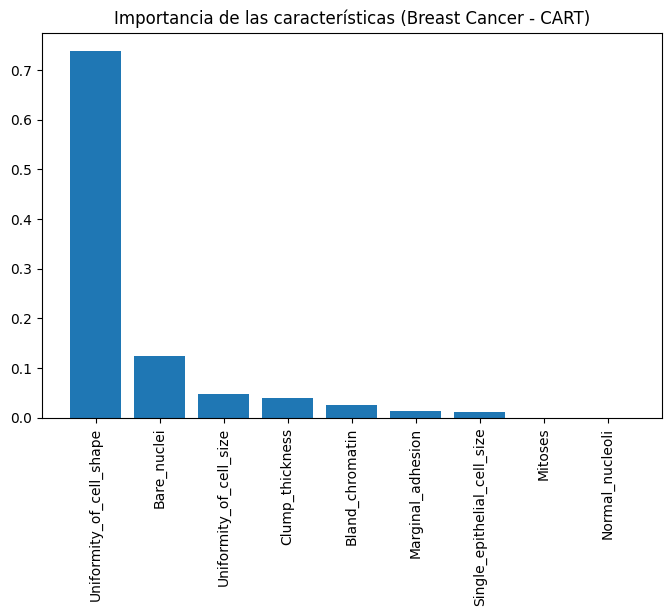

In [26]:
# Obtener las variables más importantes
importances = best_clf_cart_breast.tree.feature_importances_
# Obtener los nombres de las características
feature_names = data_breast_cancer.columns[:-1]
# Ordenar las características por importancia
indices = np.argsort(importances)[::-1]
# Graficar las importancias
plt.figure(figsize=(8, 5))
plt.title("Importancia de las características (Breast Cancer - CART)")
plt.bar(range(X_train_breast_cancer.shape[1]), importances[indices])
plt.xticks(range(X_train_breast_cancer.shape[1]), feature_names[indices], rotation=90)
plt.show()

### Para el conjunto de datos de arroz

In [27]:
# Definición de los parámetros a probar
param_grid = {'ccp_alpha': [0.00001, 0.0004, 0.0003, 0.0005, 0.0008, 0.001, 0.002, 0.003, 0.005, 0.01, 0.015, 0.1]}
# Inicialización de GridSearchCV con validación cruzada de 5 particiones (20% de los datos para prueba)
grid_search = GridSearchCV(CARTClassifier(), param_grid, cv=5)

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
grid_search.fit(X_train_rice, y_train_rice)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [28]:
print("Mejores parámetros (Rice - CART):", best_params)
print("Mejor puntuación F1 (Rice - CART):", best_score)
print("Tiempo total de preparación y ajuste de parámetros (Rice - CART):", total_time)

Mejores parámetros (Rice - CART): {'ccp_alpha': 0.002}
Mejor puntuación F1 (Rice - CART): 0.9288045438638994
Tiempo total de preparación y ajuste de parámetros (Rice - CART): 2.4917235374450684


In [29]:
# Obtener el mejor clasificador
best_clf_cart_rice = grid_search.best_estimator_

# Entrenar el mejor clasificador
best_clf_cart_rice.fit(X_train_rice, y_train_rice)

# Predecir las etiquetas de clase para los datos de prueba
y_pred_cart_rice = best_clf_cart_rice.predict(X_test_rice)


In [30]:
rice_results_cart = {}
rice_results_cart['accuracy'] = accuracy_score(y_test_rice, y_pred_cart_rice)
rice_results_cart['f1'] = f1_score(y_test_rice, y_pred_cart_rice)
rice_results_cart['recall'] = recall_score(y_test_rice, y_pred_cart_rice)
rice_results_cart['precision'] = precision_score(y_test_rice, y_pred_cart_rice)
rice_results_cart["time"] = total_time
rice_results_cart["best_params"] = f"cp = {best_params}"
rice_results_cart["confusion_matrix"] = confusion_matrix(y_test_rice, y_pred_cart_rice)

with open('rice_results_cart.txt', 'w') as file:
    file.write(str(rice_results_cart))

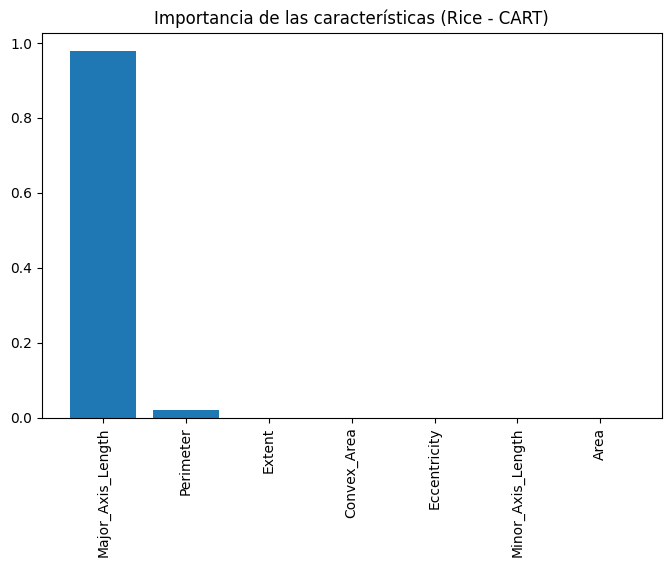

In [31]:
importances = best_clf_cart_rice.tree.feature_importances_

# Obtener los nombres de las características
feature_names = data_rice.columns[:-1]

# Ordenar las características por importancia
indices = np.argsort(importances)[::-1]

# Graficar las importancias
plt.figure(figsize=(8, 5))
plt.title("Importancia de las características (Rice - CART)")
plt.bar(range(X_train_rice.shape[1]), importances[indices])
plt.xticks(range(X_train_rice.shape[1]), feature_names[indices], rotation=90)
plt.show()

### Para el dataset de frijoles

In [32]:
# Definición de los parámetros a probar
param_grid = {'ccp_alpha': [0.00001, 0.0004, 0.0003, 0.0005, 0.0008, 0.001, 0.002, 0.003, 0.005, 0.05, 0.01, 0.015, 0.1]}
# Inicialización de GridSearchCV con validación cruzada de 5 particiones (20% de los datos para prueba)
grid_search = GridSearchCV(CARTClassifier(), param_grid, cv=5)

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
grid_search.fit(X_dry_bean, y_dry_bean)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [33]:
print("Mejores parámetros (Beans - CART):", best_params)
print("Mejor puntuación F1 (Beans - CART):", best_score)
print("Tiempo total de preparación y ajuste de parámetros (Beans - CART):", total_time)

Mejores parámetros (Beans - CART): {'ccp_alpha': 0.015}
Mejor puntuación F1 (Beans - CART): 0.7541868692497011
Tiempo total de preparación y ajuste de parámetros (Beans - CART): 56.313891649246216


In [34]:
# Obtener el mejor clasificador
best_clf_cart_dry_bean = grid_search.best_estimator_

# Entrenar el mejor clasificador
best_clf_cart_dry_bean.fit(X_train_dry_bean, y_train_dry_bean)

# Predecir las etiquetas de clase para los datos de prueba
y_pred_cart_dry_bean = best_clf_cart_dry_bean.predict(X_test_dry_bean)

In [35]:
# Resultados de clasificación
dry_bean_results_cart = classification_report(y_test_dry_bean, y_pred_cart_dry_bean, output_dict=True)
dry_bean_results_cart['accuracy'] = accuracy_score(y_test_dry_bean, y_pred_cart_dry_bean)
dry_bean_results_cart["time"] = total_time
dry_bean_results_cart["best_params"] = f"cp = {best_params}"
dry_bean_results_cart["confusion_matrix"] = confusion_matrix(y_test_dry_bean, y_pred_cart_dry_bean)

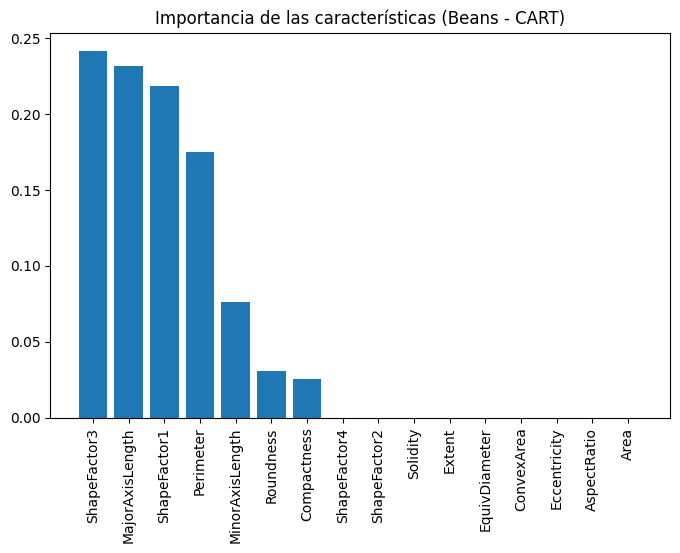

In [36]:
importances = best_clf_cart_dry_bean.tree.feature_importances_

# Obtener los nombres de las características
feature_names = data_dry_bean.columns[:-1]

# Ordenar las características por importancia
indices = np.argsort(importances)[::-1]

# Graficar las importancias
plt.figure(figsize=(8, 5))
plt.title("Importancia de las características (Beans - CART)")
plt.bar(range(X_train_dry_bean.shape[1]), importances[indices])
plt.xticks(range(X_train_dry_bean.shape[1]), feature_names[indices], rotation=90)
plt.show()

## Pruebas con RandomForest

### Para el conjunto de datos de cáncer de mama de Wisconsin

In [145]:
param_distributions = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'max_samples': [0.1, 0.5, 0.6, 0.7, 0.8, 0.9, None]  # O un rango de valores que consideres adecuados
}

random_search = RandomizedSearchCV(RandomForestClassifierOptimized(), param_distributions, n_iter=100, cv=5, random_state=42)

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
random_search.fit(X_train_breast_cancer, y_train_breast_cancer)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de RandomizedSearchCV
best_params = random_search.best_params_
best_score = random_search.best_score_

In [146]:
print("Mejores parámetros (Breast Cancer - RF):", best_params)
print("Mejor puntuación F1 (Breast Cancer - RF):", best_score)
print("Tiempo total de preparación y ajuste de parámetros (Breast Cancer - RF):", total_time)

Mejores parámetros (Breast Cancer - RF): {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.1}
Mejor puntuación F1 (Breast Cancer - RF): 0.9780316930775645
Tiempo total de preparación y ajuste de parámetros (Breast Cancer - RF): 78.48414897918701


In [151]:
# Obtener el mejor clasificador
best_clf_rf_breast = random_search.best_estimator_

# Entrenar el mejor clasificador
best_clf_rf_breast.fit(X_train_breast_cancer, y_train_breast_cancer)

# Predecir las etiquetas de clase para los datos de prueba
y_pred_rf_breast = best_clf_rf_breast.predict(X_test_breast_cancer)

breast_cancer_results_rf = {}
breast_cancer_results_rf['accuracy'] = accuracy_score(y_test_breast_cancer, y_pred_rf_breast)
breast_cancer_results_rf['f1'] = f1_score(y_test_breast_cancer, y_pred_rf_breast)
breast_cancer_results_rf['recall'] = recall_score(y_test_breast_cancer, y_pred_rf_breast)
breast_cancer_results_rf['precision'] = precision_score(y_test_breast_cancer, y_pred_rf_breast)
breast_cancer_results_rf["time"] = total_time
breast_cancer_results_rf["best_params"] = f"n = {best_params['n_estimators']}, m = {best_params['max_features']}, s = {best_params['max_samples']}"
breast_cancer_results_rf["confusion_matrix"] = confusion_matrix(y_test_breast_cancer, y_pred_rf_breast)

In [152]:
breast_cancer_results_rf

{'accuracy': 0.9635036496350365,
 'f1': 0.9494949494949494,
 'recall': 0.9791666666666666,
 'precision': 0.9215686274509803,
 'time': 686.0711133480072,
 'best_params': 'n = 100, m = 0.2, s = 0.1',
 'confusion_matrix': array([[85,  4],
        [ 1, 47]], dtype=int64)}

### Para el conjunto de datos de arroz

In [149]:
param_distributions = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'max_samples': [0.1, 0.5, 0.6, 0.7, 0.8, 0.9, None]  # O un rango de valores que consideres adecuados
}

random_search = RandomizedSearchCV(RandomForestClassifierOptimized(), param_distributions, n_iter=100, cv=5, random_state=42)

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
random_search.fit(X_train_rice, y_train_rice)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de RandomizedSearchCV
best_params = random_search.best_params_
best_score = random_search.best_score_

In [150]:
# Obtener el mejor clasificador
best_clf_rf_rice = random_search.best_estimator_

# Entrenar el mejor clasificador
best_clf_rf_rice.fit(X_train_rice, y_train_rice)

# Predecir las etiquetas de clase para los datos de prueba
y_pred_rf_rice = best_clf_rf_rice.predict(X_test_rice)

rice_results_rf = {}
rice_results_rf['accuracy'] = accuracy_score(y_test_rice, y_pred_rf_rice)
rice_results_rf['f1'] = f1_score(y_test_rice, y_pred_rf_rice)
rice_results_rf['recall'] = recall_score(y_test_rice, y_pred_rf_rice)
rice_results_rf['precision'] = precision_score(y_test_rice, y_pred_rf_rice)
rice_results_rf["time"] = total_time
rice_results_rf["best_params"] = f"n = {best_params['n_estimators']}, m = {best_params['max_features']}, s = {best_params['max_samples']}"
rice_results_rf["confusion_matrix"] = confusion_matrix(y_test_rice, y_pred_rf_rice)

In [153]:
rice_results_rf

{'accuracy': 0.9146981627296588,
 'f1': 0.9267192784667418,
 'recall': 0.9426605504587156,
 'precision': 0.9113082039911308,
 'time': 686.0711133480072,
 'best_params': 'n = 100, m = 0.2, s = 0.1',
 'confusion_matrix': array([[286,  40],
        [ 25, 411]], dtype=int64)}

### Para el dataset de frijoles

In [31]:
# Definición de los parámetros a probar
param_distributions = {
    'n_estimators': [10, 50, 100],
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.1, 1.1, 0.1)),
    'max_samples': [0.1, 0.5, 0.8, 0.9, None]  # O un rango de valores que consideres adecuados
}

random_search = RandomizedSearchCV(RandomForestClassifierOptimized(), param_distributions, n_iter=100, cv=5, random_state=42)

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
random_search.fit(X_train_dry_bean, y_train_dry_bean)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de RandomizedSearchCV
best_params = random_search.best_params_
best_score = random_search.best_score_

In [ ]:
# Obtener el mejor clasificador
best_clf_rf_dry_bean = random_search.best_estimator_

# Entrenar el mejor clasificador
best_clf_rf_dry_bean.fit(X_train_dry_bean, y_train_dry_bean)

# Predecir las etiquetas de clase para los datos de prueba
y_pred_rf_dry_bean = best_clf_rf_dry_bean.predict(X_test_dry_bean)

dry_bean_results_rf = classification_report(y_test_dry_bean, y_pred_rf_dry_bean, output_dict=True)
dry_bean_results_rf['accuracy'] = accuracy_score(y_test_dry_bean, y_pred_rf_dry_bean)
dry_bean_results_rf["time"] = total_time
dry_bean_results_rf["best_params"] = f"n = {best_params['n_estimators']}, m = {best_params['max_features']}, s = {best_params['max_samples']}"



In [33]:
with open('dry_bean_results_rf.txt', 'w') as file:
    file.write(str(dry_bean_results_rf))

### KNN
Para el conjunto de datos de cáncer de mama de Wisconsin

In [19]:
knn = KNNClassifier()

# Definir un diccionario con los rangos de parámetros a probar
param_grid = {
    'n_neighbors': [5, 7, 8, 9, 10, 15],
}

# Inicializar GridSearchCV con validación cruzada de 5 particiones (20% de los datos para prueba)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
grid_search.fit(X_train_breast_cancer, y_train_breast_cancer)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [20]:
print("Mejores parámetros (Breast Cancer - KNN):", best_params)
print("Mejor puntuación F1 (Breast Cancer - KNN):", best_score)
print("Tiempo total de preparación y ajuste de parámetros (Breast Cancer - KNN):", total_time)

Mejores parámetros (Breast Cancer - KNN): {'n_neighbors': 7}
Mejor puntuación F1 (Breast Cancer - KNN): 0.9629882720113342
Tiempo total de preparación y ajuste de parámetros (Breast Cancer - KNN): 11.682685852050781


In [21]:
# Obtener el mejor clasificador
best_clf_knn_breast = grid_search.best_estimator_

# Entrenar el mejor clasificador
best_clf_knn_breast.fit(X_train_breast_cancer, y_train_breast_cancer)

# Predecir las etiquetas de clase para los datos de prueba
y_pred_knn_breast = best_clf_knn_breast.predict(X_test_breast_cancer)

breast_cancer_results_knn = {}
breast_cancer_results_knn['accuracy'] = accuracy_score(y_test_breast_cancer, y_pred_knn_breast)
breast_cancer_results_knn['f1'] = f1_score(y_test_breast_cancer, y_pred_knn_breast)
breast_cancer_results_knn['recall'] = recall_score(y_test_breast_cancer, y_pred_knn_breast)
breast_cancer_results_knn['precision'] = precision_score(y_test_breast_cancer, y_pred_knn_breast)
breast_cancer_results_knn["time"] = total_time
breast_cancer_results_knn["best_params"] = f"k = {best_params['n_neighbors']}"
breast_cancer_results_knn["confusion_matrix"] = confusion_matrix(y_test_breast_cancer, y_pred_knn_breast)

with open('breast_cancer_results_knn.txt', 'w') as file:
    file.write(str(breast_cancer_results_knn))

### Para el conjunto de datos de arroz

In [22]:
param_grid = {
    'n_neighbors': [5, 7, 8, 9, 10, 15],
}

# Inicializar GridSearchCV con validación cruzada de 5 particiones (20% de los datos para prueba)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
grid_search.fit(X_train_rice, y_train_rice)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_


In [23]:
print("Mejores parámetros (Rice - KNN):", best_params)
print("Mejor puntuación F1 (Rice - KNN):", best_score)
print("Tiempo total de preparación y ajuste de parámetros (Rice - KNN):", total_time)

Mejores parámetros (Rice - KNN): {'n_neighbors': 7}
Mejor puntuación F1 (Rice - KNN): 0.9386749054019443
Tiempo total de preparación y ajuste de parámetros (Rice - KNN): 401.91310596466064


In [24]:
# Obtener el mejor clasificador
best_clf_knn_rice = grid_search.best_estimator_

# Entrenar el mejor clasificador
best_clf_knn_rice.fit(X_train_rice, y_train_rice)

# Predecir las etiquetas de clase para los datos de prueba
y_pred_knn_rice = best_clf_knn_rice.predict(X_test_rice)

rice_results_knn = {}
rice_results_knn['accuracy'] = accuracy_score(y_test_rice, y_pred_knn_rice)
rice_results_knn['f1'] = f1_score(y_test_rice, y_pred_knn_rice)
rice_results_knn['recall'] = recall_score(y_test_rice, y_pred_knn_rice)
rice_results_knn['precision'] = precision_score(y_test_rice, y_pred_knn_rice)
rice_results_knn["time"] = total_time
rice_results_knn["best_params"] = f"k = {best_params['n_neighbors']}"
rice_results_knn["confusion_matrix"] = confusion_matrix(y_test_rice, y_pred_knn_rice)

In [26]:
with open('rice_results_knn.txt', 'w') as file:
    file.write(str(rice_results_knn))

### Para el dataset de frijoles

In [28]:
param_grid = {
    'n_neighbors': [8, 9, 10, 15],
}

# Inicializar GridSearchCV con validación cruzada de 5 particiones (20% de los datos para prueba)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_macro')

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
grid_search.fit(X_train_dry_bean, y_train_dry_bean)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [29]:
print("Mejores parámetros (Beans - KNN):", best_params)
print("Mejor puntuación F1 (Beans - KNN):", best_score)
print("Tiempo total de preparación y ajuste de parámetros (Beans - KNN):", total_time)

Mejores parámetros (Beans - KNN): {'n_neighbors': 8}
Mejor puntuación F1 (Beans - KNN): 0.70793128611238
Tiempo total de preparación y ajuste de parámetros (Beans - KNN): 3096.580188035965


In [30]:

# Obtener el mejor clasificador
best_clf_knn_dry_bean = grid_search.best_estimator_

# Entrenar el mejor clasificador
best_clf_knn_dry_bean.fit(X_train_dry_bean, y_train_dry_bean)

# Predecir las etiquetas de clase para los datos de prueba
y_pred_knn_dry_bean = best_clf_knn_dry_bean.predict(X_test_dry_bean)

# Resultados de clasificación
dry_bean_results_knn = classification_report(y_test_dry_bean, y_pred_knn_dry_bean, output_dict=True)
dry_bean_results_knn['accuracy'] = accuracy_score(y_test_dry_bean, y_pred_knn_dry_bean)
dry_bean_results_knn["time"] = total_time
dry_bean_results_knn["best_params"] = f"k = {best_params['n_neighbors']}"
dry_bean_results_knn["confusion_matrix"] = confusion_matrix(y_test_dry_bean, y_pred_knn_dry_bean)

with open('dry_bean_results_knn.txt', 'w') as file:
    file.write(str(dry_bean_results_knn))

In [156]:
# Save all results

with open('breast_cancer_results_kde.txt', 'w') as file:
    file.write(str(breast_cancer_results_kde))

with open('rice_results_kde.txt', 'w') as file:
    file.write(str(rice_results_kde))

with open('dry_bean_results_kde.txt', 'w') as file:
    file.write(str(dry_bean_results_kde))

with open('breast_cancer_results_cart.txt', 'w') as file:
    file.write(str(breast_cancer_results_cart))

with open('rice_results_cart.txt', 'w') as file:
    file.write(str(rice_results_cart))

with open('dry_bean_results_cart.txt', 'w') as file:
    file.write(str(dry_bean_results_cart))

with open('breast_cancer_results_rf.txt', 'w') as file:
    file.write(str(breast_cancer_results_rf))

with open('rice_results_rf.txt', 'w') as file:
    file.write(str(rice_results_rf))

# SVM

In [62]:
param_grid = {
    'C': [0.1, 1, 10, 50, 60, 70, 80, 90, 100],
    'gamma': [0.1, 0.01, 0.001, 0.0001, 0.005, 'scale'],
    'kernel': ['rbf', 'linear']
}

# Crear una instancia de GridSearchCV con la clase SVMOptimizer y el espacio de búsqueda
grid_search = GridSearchCV(SVMOptimizer(), param_grid, cv=5)

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
grid_search.fit(X_train_breast_cancer, y_train_breast_cancer)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [63]:
print("Mejores parámetros (Breast Cancer - SVM):", best_params)
print("Mejor puntuación F1 (Breast Cancer - SVM):", best_score)
print("Tiempo total de preparación y ajuste de parámetros (Breast Cancer - SVM):", total_time)

Mejores parámetros (Breast Cancer - SVM): {'C': 69, 'gamma': 0.0001, 'kernel': 'rbf'}
Mejor puntuación F1 (Breast Cancer - SVM): 0.9725437864887407
Tiempo total de preparación y ajuste de parámetros (Breast Cancer - SVM): 12.407183647155762


In [64]:
# Obtener el mejor clasificador
best_clf_svm_breast = grid_search.best_estimator_

# Predecir las etiquetas de clase para los datos de prueba
y_pred_svm_breast = best_clf_svm_breast.predict(X_test_breast_cancer)

breast_cancer_results_svm = {}
breast_cancer_results_svm['accuracy'] = accuracy_score(y_test_breast_cancer, y_pred_svm_breast)
breast_cancer_results_svm['f1'] = f1_score(y_test_breast_cancer, y_pred_svm_breast)
breast_cancer_results_svm['recall'] = recall_score(y_test_breast_cancer, y_pred_svm_breast)
breast_cancer_results_svm['precision'] = precision_score(y_test_breast_cancer, y_pred_svm_breast)
breast_cancer_results_svm["time"] = total_time
breast_cancer_results_svm["best_params"] = f"C = {best_params['C']}, gamma = {best_params['gamma']}, kernel = {best_params['kernel']}"
breast_cancer_results_svm["confusion_matrix"] = confusion_matrix(y_test_breast_cancer, y_pred_svm_breast)

with open('breast_cancer_results_svm.txt', 'w') as file:
    file.write(str(breast_cancer_results_svm))

### Para el conjunto de datos de arroz

In [69]:
param_grid = {
    'C': [0.1, 1, 5, 6, 6.5, 7, 8, 9, 10, 20],
    'gamma': [1, 0.5, 0.1, 0.01, 'scale'],
    'kernel': ['rbf']
}

# Crear una instancia de GridSearchCV con la clase SVMOptimizer y el espacio de búsqueda
grid_search = GridSearchCV(SVMOptimizer(), param_grid, cv=5)

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
grid_search.fit(X_train_rice, y_train_rice)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de GridSearchCV
best_params = grid_search.best_params_

# Obtener el mejor clasificador
best_clf_svm_rice = grid_search.best_estimator_

best_score = grid_search.best_score_

In [71]:
print("Mejores parámetros (Rice - SVM):", best_params)
print("Mejor puntuación F1 (Rice - SVM):", best_score)
print("Tiempo total de preparación y ajuste de parámetros (Rice - SVM):", total_time)

Mejores parámetros (Rice - SVM): {'C': 6, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor puntuación F1 (Rice - SVM): 0.9725437864887407
Tiempo total de preparación y ajuste de parámetros (Rice - SVM): 28.33565664291382


In [72]:
# Predecir las etiquetas de clase para los datos de prueba
y_pred_svm_rice = best_clf_svm_rice.predict(X_test_rice)

rice_results_svm = {}
rice_results_svm['accuracy'] = accuracy_score(y_test_rice, y_pred_svm_rice)
rice_results_svm['f1'] = f1_score(y_test_rice, y_pred_svm_rice)
rice_results_svm['recall'] = recall_score(y_test_rice, y_pred_svm_rice)
rice_results_svm['precision'] = precision_score(y_test_rice, y_pred_svm_rice)
rice_results_svm["time"] = total_time
rice_results_svm["best_params"] = f"C = {best_params['C']}, gamma = {best_params['gamma']}, kernel = {best_params['kernel']}"
rice_results_svm["confusion_matrix"] = confusion_matrix(y_test_rice, y_pred_svm_rice)

with open('rice_results_svm.txt', 'w') as file:
    file.write(str(rice_results_svm))

### Para el dataset de frijoles

In [36]:
param_grid = {
    'C': [0.01, 0.1, 1],
    'kernel': ['linear']
}

# Crear una instancia de GridSearchCV con la clase SVMOptimizer y el espacio de búsqueda
grid_search = GridSearchCV(SVMOptimizer(), param_grid, cv=5, n_jobs=-1, verbose=2)

# Medición del tiempo de "preparación" y ajuste de parámetros
start_time = time.time()
grid_search.fit(X_train_dry_bean, y_train_dry_bean)
end_time = time.time()

# Tiempo total utilizado en el proceso
total_time = end_time - start_time

# Resultados de GridSearchCV
best_params = grid_search.best_params_

# Obtener el mejor clasificador
best_clf_svm_dry_bean = grid_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [1]:
print("Mejores parámetros (Beans - SVM):", best_params)
print("Mejor puntuación F1 (Beans - SVM):", best_score)
print("Tiempo total de preparación y ajuste de parámetros (Beans - SVM):", total_time)

Mejores parámetros (Beans - SVM): {'C': 1, 'kernel': 'linear'}
Mejor puntuación F1 (Beans - SVM): 0.9149529284577517
Tiempo total de preparación y ajuste de parámetros (Beans - SVM): 661.5432448387146


In [ ]:
# Leer 

In [ ]:
# Obtener el mejor clasificador
best_clf_rf_breast = random_search.best_estimator_

# Predecir las etiquetas de clase para los datos de prueba
y_pred_svm_rice = 

